In [1]:
pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 2.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 7.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import matplotlib.pyplot as plt

In [4]:
# Valid intervals: [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]

NUM_DAYS = 12    # The number of days of historical data to retrieve
INTERVAL = '2m'     # Sample rate of historical data
symbol = 'LAURUSLABS.NS'      # Symbol of the desired stock
end_date = datetime.date(2023, 8, 22)
pred_date = end_date + datetime.timedelta(1)

[*********************100%%**********************]  1 of 1 completed
                                close
Datetime                             
2023-08-10 09:15:00+05:30  411.450012
2023-08-10 09:17:00+05:30  411.600006
2023-08-10 09:19:00+05:30  410.850006
2023-08-10 09:21:00+05:30  410.350006
2023-08-10 09:23:00+05:30  409.500000
...                               ...
2023-08-21 15:21:00+05:30  389.500000
2023-08-21 15:23:00+05:30  389.149994
2023-08-21 15:25:00+05:30  388.399994
2023-08-21 15:27:00+05:30  388.399994
2023-08-21 15:29:00+05:30  389.600006

[1316 rows x 1 columns]
(1316, 1)
(1316, 1)


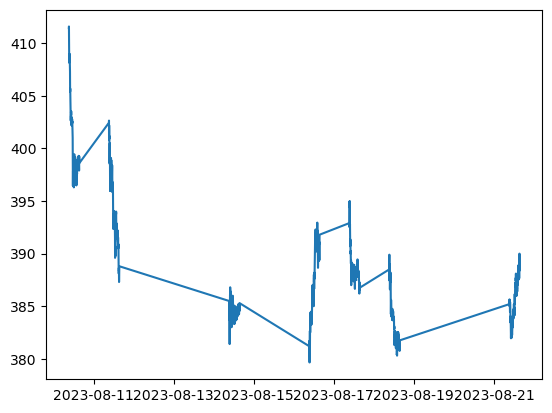

In [5]:
start = (end_date - datetime.timedelta(NUM_DAYS))
end = end_date
df = yf.download(symbol, start = start, end = end, interval = INTERVAL)
df.rename(columns = { 'Close' : 'close', 'Open' : 'open', 'High' : 'high', 'Low' : 'low', 'Volume' : 'volume'}, inplace = True)
df = df.iloc[:,3:4]
train_dataset = df.values

print(df)
print(df.shape)
print(train_dataset.shape)
# df['close'].plot()
tmp = df[-150:]
plt.plot(df)


[*********************100%%**********************]  1 of 1 completed
                                close
Datetime                             
2023-08-23 09:15:00+05:30  394.450012
2023-08-23 09:17:00+05:30  393.600006
2023-08-23 09:19:00+05:30  392.000000
2023-08-23 09:21:00+05:30  392.450012
2023-08-23 09:23:00+05:30  392.600006
...                               ...
2023-08-23 15:21:00+05:30  395.450012
2023-08-23 15:23:00+05:30  395.450012
2023-08-23 15:25:00+05:30  395.299988
2023-08-23 15:27:00+05:30  395.649994
2023-08-23 15:29:00+05:30  395.450012

[188 rows x 1 columns]
(188, 1)


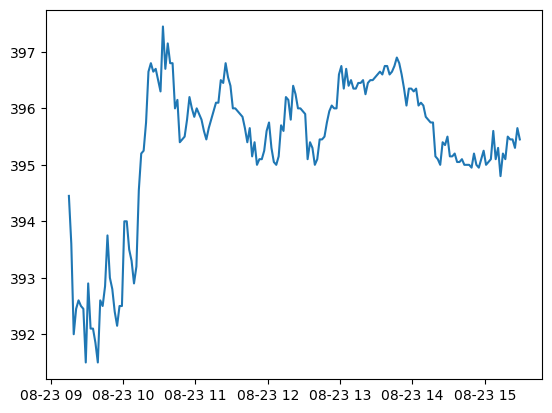

In [6]:
TEST_DAYS = 1
test_start = (pred_date)
test_end = (pred_date + datetime.timedelta(TEST_DAYS))
test_df = yf.download(symbol, start = test_start, end = test_end, interval = INTERVAL)
test_df.rename(columns = { 'Close' : 'close', 'Open' : 'open', 'High' : 'high', 'Low' : 'low', 'Volume' : 'volume'}, inplace = True)
test_df = test_df.iloc[:,3:4]
test_dataset = test_df.values

print(test_df)
print(test_df.shape)
tmp1 = test_df[-150:]
plt.plot(test_df)



In [7]:
#Preprocessing the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
train_dataset_scaled = sc.fit_transform(train_dataset)
print(train_dataset_scaled)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[[0.99530536]
 [1.        ]
 [0.97652583]
 ...
 [0.27386531]
 [0.27386531]
 [0.31142436]]


In [8]:
#Creating a data structure with 120 timesteps and 1 output
n = 120
X_train = []
y_train = []
for i in range(n, train_dataset.shape[0]):
    X_train.append(train_dataset_scaled[i-n:i, 0])
    y_train.append(train_dataset_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [9]:
print(X_train)

[[0.99530536 1.         0.97652583 ... 0.55868542 0.55399078 0.56807471]
 [1.         0.97652583 0.96087638 ... 0.55399078 0.56807471 0.57120479]
 [0.97652583 0.96087638 0.93427213 ... 0.56807471 0.57120479 0.56651015]
 ...
 [0.13458581 0.12832565 0.13302029 ... 0.30203412 0.30829428 0.29733948]
 [0.12832565 0.13302029 0.1439751  ... 0.30829428 0.29733948 0.27386531]
 [0.13302029 0.1439751  0.15336438 ... 0.29733948 0.27386531 0.27386531]]


In [10]:
#Reshaping the input datas structure
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [11]:
print(X_train.shape)

(1196, 120, 1)


In [12]:
#Importing the keras packages
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [13]:
#Initialising the regressor
regressor = Sequential()

In [14]:
#Adding the first LSTM layer and some dropout regularisation layer
regressor.add(LSTM(units = 150, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
#Layer 2
regressor.add(LSTM(units = 150, return_sequences = True))
regressor.add(Dropout(0.2))
#Layer 3
regressor.add(LSTM(units = 150, return_sequences = True))
regressor.add(Dropout(0.2))
#Layer 4
regressor.add(LSTM(units = 150, return_sequences = False))
regressor.add(Dropout(0.2))

In [15]:
#Output layer
regressor.add(Dense(units = 1))

In [16]:
#Compile the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [17]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 [==============================] - 12s 28ms/step - loss: 0.0093
Epoch 2/100
38/38 [==============================] - 1s 27ms/step - loss: 0.0027
Epoch 3/100
38/38 [==============================] - 1s 27ms/step - loss: 0.0019
Epoch 4/100
38/38 [==============================] - 1s 27ms/step - loss: 0.0019
Epoch 5/100
38/38 [==============================] - 1s 27ms/step - loss: 0.0019
Epoch 6/100
38/38 [==============================] - 1s 27ms/step - loss: 0.0021
Epoch 7/100
38/38 [==============================] - 1s 27ms/step - loss: 0.0016
Epoch 8/100
38/38 [==============================] - 1s 27ms/step - loss: 0.0018
Epoch 9/100
38/38 [==============================] - 1s 29ms/step - loss: 0.0018
Epoch 10/100
38/38 [==============================] - 1s 26ms/step - loss: 0.0014
Epoch 11/100
38/38 [==============================] - 1s 27ms/step - loss: 0.0013
Epoch 12/100
38/38 [==============================] - 1s 27ms/step - loss: 0.0013
Epoch 13/100
38/38 [====

In [18]:
#Getting the total dataset
total_dataset = pd.concat((df['close'], test_df['close']), axis = 0)
inputs = total_dataset[len(total_dataset)-len(test_df)-n:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)
print(len(test_df))

(308, 1)
188


In [19]:
#Creating the data structure
X_test = []
for i in range(n,n+len(test_df)):
    X_test.append(inputs[i-n:i, 0])
    
X_test = np.array(X_test)
# print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

6/6 [==============================] - 2s 14ms/step


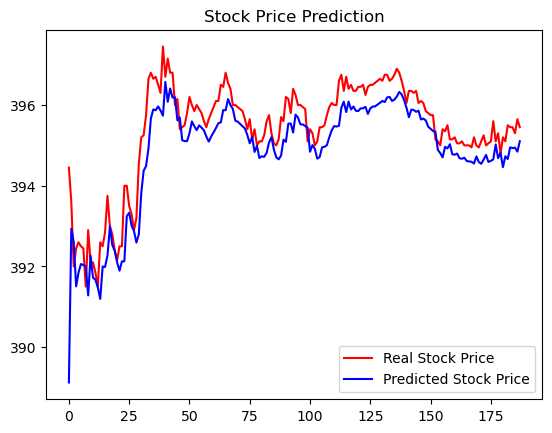

In [20]:
#Plotting
plt.plot(test_dataset, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()

In [21]:
mse = ((test_dataset - predicted_stock_price)**2).mean(axis=0)
print(mse)

[0.53908877]
